# Optimization with Diagram Distances

In [1]:
import time
import torch
import torch.nn as nn
import torch_tda
import numpy as np
import matplotlib.pyplot as plt
import bats
from tqdm import tqdm

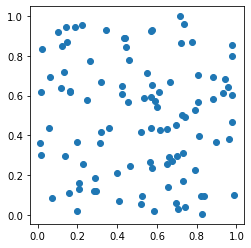

In [2]:
n = 100
np.random.seed(0)
data = np.random.uniform(0,1,(n,2))
fig1 = plt.scatter(data[:,0], data[:,1])
fig1.axes.set_aspect('equal')
X = torch.tensor(data, requires_grad=True)

In [3]:
# Compute H1 and H0
# maximum homology dimension is 1, which implies C_2 needed
# flags = (bats.standard_reduction_flag(), bats.compute_basis_flag())
flags = (bats.standard_reduction_flag(),bats.compression_flag())
# flags = ()
layer = torch_tda.nn.RipsLayer(maxdim = 1, reduction_flags=flags) 
# dgms = layer(X) # run FlagDiagram.forward()

In [4]:
dgm0 = layer(X)

In [5]:
f1 = torch_tda.nn.BarcodePolyFeature(1,2,0)

we'll produce a perturbed data set

In [6]:
# take a few gradient descent steps
optimizer = torch.optim.Adam([X], lr=1e-2)
for i in tqdm(range(2)):
    optimizer.zero_grad()
    dgms = layer(X)
    loss = -f1(dgms) 
    loss.backward()
    optimizer.step()

100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


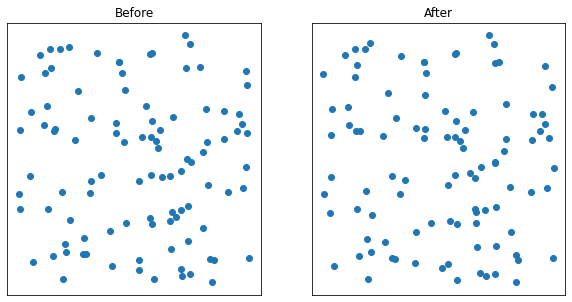

In [7]:
y = X.detach().numpy()
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(data[:,0], data[:,1])
ax[0].set_title("Before")
ax[1].scatter(y[:,0], y[:,1])
ax[1].set_title("After")
for i in range(2):
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].tick_params(bottom=False, left=False)
plt.show()

Now, let's try to decrease a diagram distance between the two diagrams.

You can either use `torch_tda.nn.WassersteinLayer()` or `torch_tda.nn.BottleneckLayer()`

In [8]:
import time

DB = torch_tda.nn.WassersteinLayer()
dgm01cpy = dgm0[1].detach()

# take a few gradient descent steps
optimizer = torch.optim.Adam([X], lr=1e-4)
losses = []
tph = []
tdb = []
for i in tqdm(range(100)):
    optimizer.zero_grad()
    t0 = time.monotonic()
    dgms = layer(X)
    t1 = time.monotonic()
    tph.append(t1 - t0)
    
    dgms0 = dgms[1]
    t0 = time.monotonic()
    loss = DB(dgms0, dgm01cpy) 
    t1 = time.monotonic()
    tdb.append(t1 - t0)
    
    losses.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()
    
np.mean(tph), np.mean(tdb)

100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


(0.15584791781002422, 0.009486365811899305)

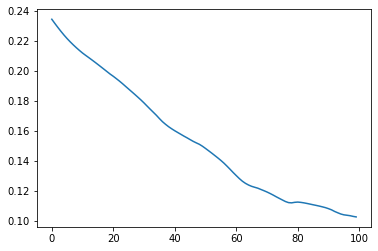

In [9]:
plt.plot(losses)
plt.show()

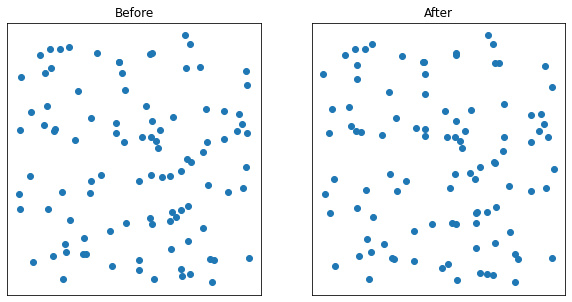

In [10]:
y = X.detach().numpy()
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

ax[0].scatter(data[:,0], data[:,1])
ax[0].set_title("Before")

ax[1].scatter(y[:,0], y[:,1])
ax[1].set_title("After")

for i in range(2):
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].tick_params(bottom=False, left=False)

plt.show()